# Stratonovich Calculus: Theory and Numerical Implementation

## 1. Introduction

Stratonovich calculus provides an alternative to Itô calculus for defining stochastic integrals. Named after Ruslan Stratonovich, this formulation preserves the chain rule of ordinary calculus, making it particularly useful in physical applications where the noise arises from underlying smooth processes.

### 1.1 Motivation

In many physical systems, noise originates from rapidly fluctuating but fundamentally smooth processes. When such systems are modeled using stochastic differential equations (SDEs), the Stratonovich interpretation often yields more physically meaningful results.

## 2. Mathematical Foundations

### 2.1 The Stratonovich Integral

Given a stochastic process $X_t$ and a Wiener process $W_t$, the **Stratonovich integral** is defined as:

$$\int_0^T f(X_t) \circ dW_t = \lim_{n \to \infty} \sum_{i=0}^{n-1} f\left(\frac{X_{t_i} + X_{t_{i+1}}}{2}\right) \left(W_{t_{i+1}} - W_{t_i}\right)$$

The key distinction from the Itô integral is the use of the **midpoint** evaluation:

$$\text{Stratonovich: } f\left(\frac{X_{t_i} + X_{t_{i+1}}}{2}\right) \quad \text{vs} \quad \text{Itô: } f(X_{t_i})$$

### 2.2 Stratonovich SDE Notation

A Stratonovich SDE is written as:

$$dX_t = a(X_t, t)\,dt + b(X_t, t) \circ dW_t$$

where the circle $\circ$ denotes Stratonovich integration.

### 2.3 The Stratonovich Chain Rule

One of the most important features of Stratonovich calculus is that the **ordinary chain rule holds**. For a smooth function $f(X_t)$:

$$df(X_t) = f'(X_t) \circ dX_t$$

This contrasts with the Itô formula, which includes an additional correction term:

$$df(X_t) = f'(X_t)\,dX_t + \frac{1}{2}f''(X_t)b^2(X_t, t)\,dt \quad \text{(Itô)}$$

### 2.4 Itô-Stratonovich Conversion

The two formulations are related by:

$$\int_0^T f(X_t) \circ dW_t = \int_0^T f(X_t)\,dW_t + \frac{1}{2}\int_0^T f'(X_t)b(X_t, t)\,dt$$

For an SDE in Stratonovich form:
$$dX_t = a(X_t)\,dt + b(X_t) \circ dW_t$$

The equivalent Itô form is:
$$dX_t = \left[a(X_t) + \frac{1}{2}b(X_t)b'(X_t)\right]dt + b(X_t)\,dW_t$$

The correction term $\frac{1}{2}b(X_t)b'(X_t)$ is called the **Wong-Zakai correction** or **noise-induced drift**.

## 3. Physical Interpretation

### 3.1 Wong-Zakai Theorem

The Wong-Zakai theorem states that when white noise $\xi_t$ is approximated by smooth colored noise $\xi_t^{\epsilon}$, the solution of:

$$\frac{dX^{\epsilon}_t}{dt} = a(X^{\epsilon}_t) + b(X^{\epsilon}_t)\xi^{\epsilon}_t$$

converges to the Stratonovich solution as $\epsilon \to 0$. This provides the physical justification for using Stratonovich calculus in systems with smooth underlying noise.

### 3.2 Geometric Applications

Stratonovich calculus is essential for:
- **Stochastic differential geometry** (preserves coordinate transformation rules)
- **Hamiltonian systems with noise** (preserves symplectic structure)
- **Langevin equations** derived from physical first principles

## 4. Numerical Implementation

We will implement and compare numerical schemes for both Itô and Stratonovich SDEs, demonstrating the conversion between them and the consequences of using the wrong interpretation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Plotting style
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['legend.fontsize'] = 10

### 4.1 Example: Geometric Brownian Motion

Consider the SDE:
$$dX_t = \mu X_t\,dt + \sigma X_t \circ dW_t \quad \text{(Stratonovich)}$$

The equivalent Itô form is:
$$dX_t = \left(\mu + \frac{\sigma^2}{2}\right) X_t\,dt + \sigma X_t\,dW_t \quad \text{(Itô)}$$

The analytical solution for the Stratonovich form is:
$$X_t = X_0 \exp\left(\mu t + \sigma W_t\right)$$

In [2]:
def euler_maruyama(x0, mu, sigma, T, N, M=1):
    """
    Euler-Maruyama scheme for Itô SDE: dX = mu*X*dt + sigma*X*dW
    
    Parameters:
    -----------
    x0 : float - Initial condition
    mu : float - Drift coefficient (Itô form)
    sigma : float - Diffusion coefficient
    T : float - Final time
    N : int - Number of time steps
    M : int - Number of sample paths
    
    Returns:
    --------
    t : array - Time grid
    X : array - Solution paths (M x (N+1))
    dW : array - Wiener increments (M x N)
    """
    dt = T / N
    t = np.linspace(0, T, N + 1)
    
    # Generate Wiener increments
    dW = np.sqrt(dt) * np.random.randn(M, N)
    
    # Initialize solution
    X = np.zeros((M, N + 1))
    X[:, 0] = x0
    
    # Euler-Maruyama iteration
    for i in range(N):
        X[:, i+1] = X[:, i] + mu * X[:, i] * dt + sigma * X[:, i] * dW[:, i]
    
    return t, X, dW


def stratonovich_heun(x0, a, b, T, N, M=1):
    """
    Heun scheme for Stratonovich SDE: dX = a*X*dt + b*X o dW
    Uses predictor-corrector approach for midpoint evaluation.
    
    Parameters:
    -----------
    x0 : float - Initial condition
    a : float - Drift coefficient (Stratonovich form)
    b : float - Diffusion coefficient
    T : float - Final time
    N : int - Number of time steps
    M : int - Number of sample paths
    
    Returns:
    --------
    t : array - Time grid
    X : array - Solution paths (M x (N+1))
    dW : array - Wiener increments (M x N)
    """
    dt = T / N
    t = np.linspace(0, T, N + 1)
    
    # Generate Wiener increments
    dW = np.sqrt(dt) * np.random.randn(M, N)
    
    # Initialize solution
    X = np.zeros((M, N + 1))
    X[:, 0] = x0
    
    # Heun (Stratonovich) iteration
    for i in range(N):
        # Predictor (Euler step)
        X_pred = X[:, i] + a * X[:, i] * dt + b * X[:, i] * dW[:, i]
        
        # Corrector (average diffusion at start and predicted endpoint)
        X[:, i+1] = X[:, i] + a * X[:, i] * dt + 0.5 * b * (X[:, i] + X_pred) * dW[:, i]
    
    return t, X, dW


def analytical_stratonovich_gbm(x0, mu, sigma, t, W):
    """
    Analytical solution for Stratonovich GBM:
    X_t = X_0 * exp(mu*t + sigma*W_t)
    """
    return x0 * np.exp(mu * t + sigma * W)

In [3]:
# Parameters
x0 = 1.0
mu = 0.5      # Drift in Stratonovich form
sigma = 0.3   # Diffusion coefficient
T = 2.0
N = 1000
M = 5         # Number of sample paths for visualization

# The Itô drift includes the correction term
mu_ito = mu + 0.5 * sigma**2

print(f"Stratonovich drift: μ = {mu}")
print(f"Equivalent Itô drift: μ_Itô = μ + σ²/2 = {mu_ito}")
print(f"Wong-Zakai correction: σ²/2 = {0.5 * sigma**2}")

Stratonovich drift: μ = 0.5
Equivalent Itô drift: μ_Itô = μ + σ²/2 = 0.545
Wong-Zakai correction: σ²/2 = 0.045


In [4]:
# Generate solutions using different methods with SAME random numbers
np.random.seed(123)

# Stratonovich Heun method
t_strat, X_strat, dW = stratonovich_heun(x0, mu, sigma, T, N, M)

# Compute Wiener process from increments
W = np.zeros((M, N + 1))
W[:, 1:] = np.cumsum(dW, axis=1)

# Analytical solution (Stratonovich form)
X_analytical = analytical_stratonovich_gbm(x0, mu, sigma, t_strat, W)

# Reset seed and use same Wiener process for Itô methods
np.random.seed(123)

# Euler-Maruyama with CORRECT Itô drift (equivalent to Stratonovich)
t_ito_correct, X_ito_correct, _ = euler_maruyama(x0, mu_ito, sigma, T, N, M)

np.random.seed(123)
# Euler-Maruyama with WRONG drift (using Stratonovich mu in Itô scheme)
t_ito_wrong, X_ito_wrong, _ = euler_maruyama(x0, mu, sigma, T, N, M)

### 4.2 Comparison: Correct vs Incorrect Interpretation

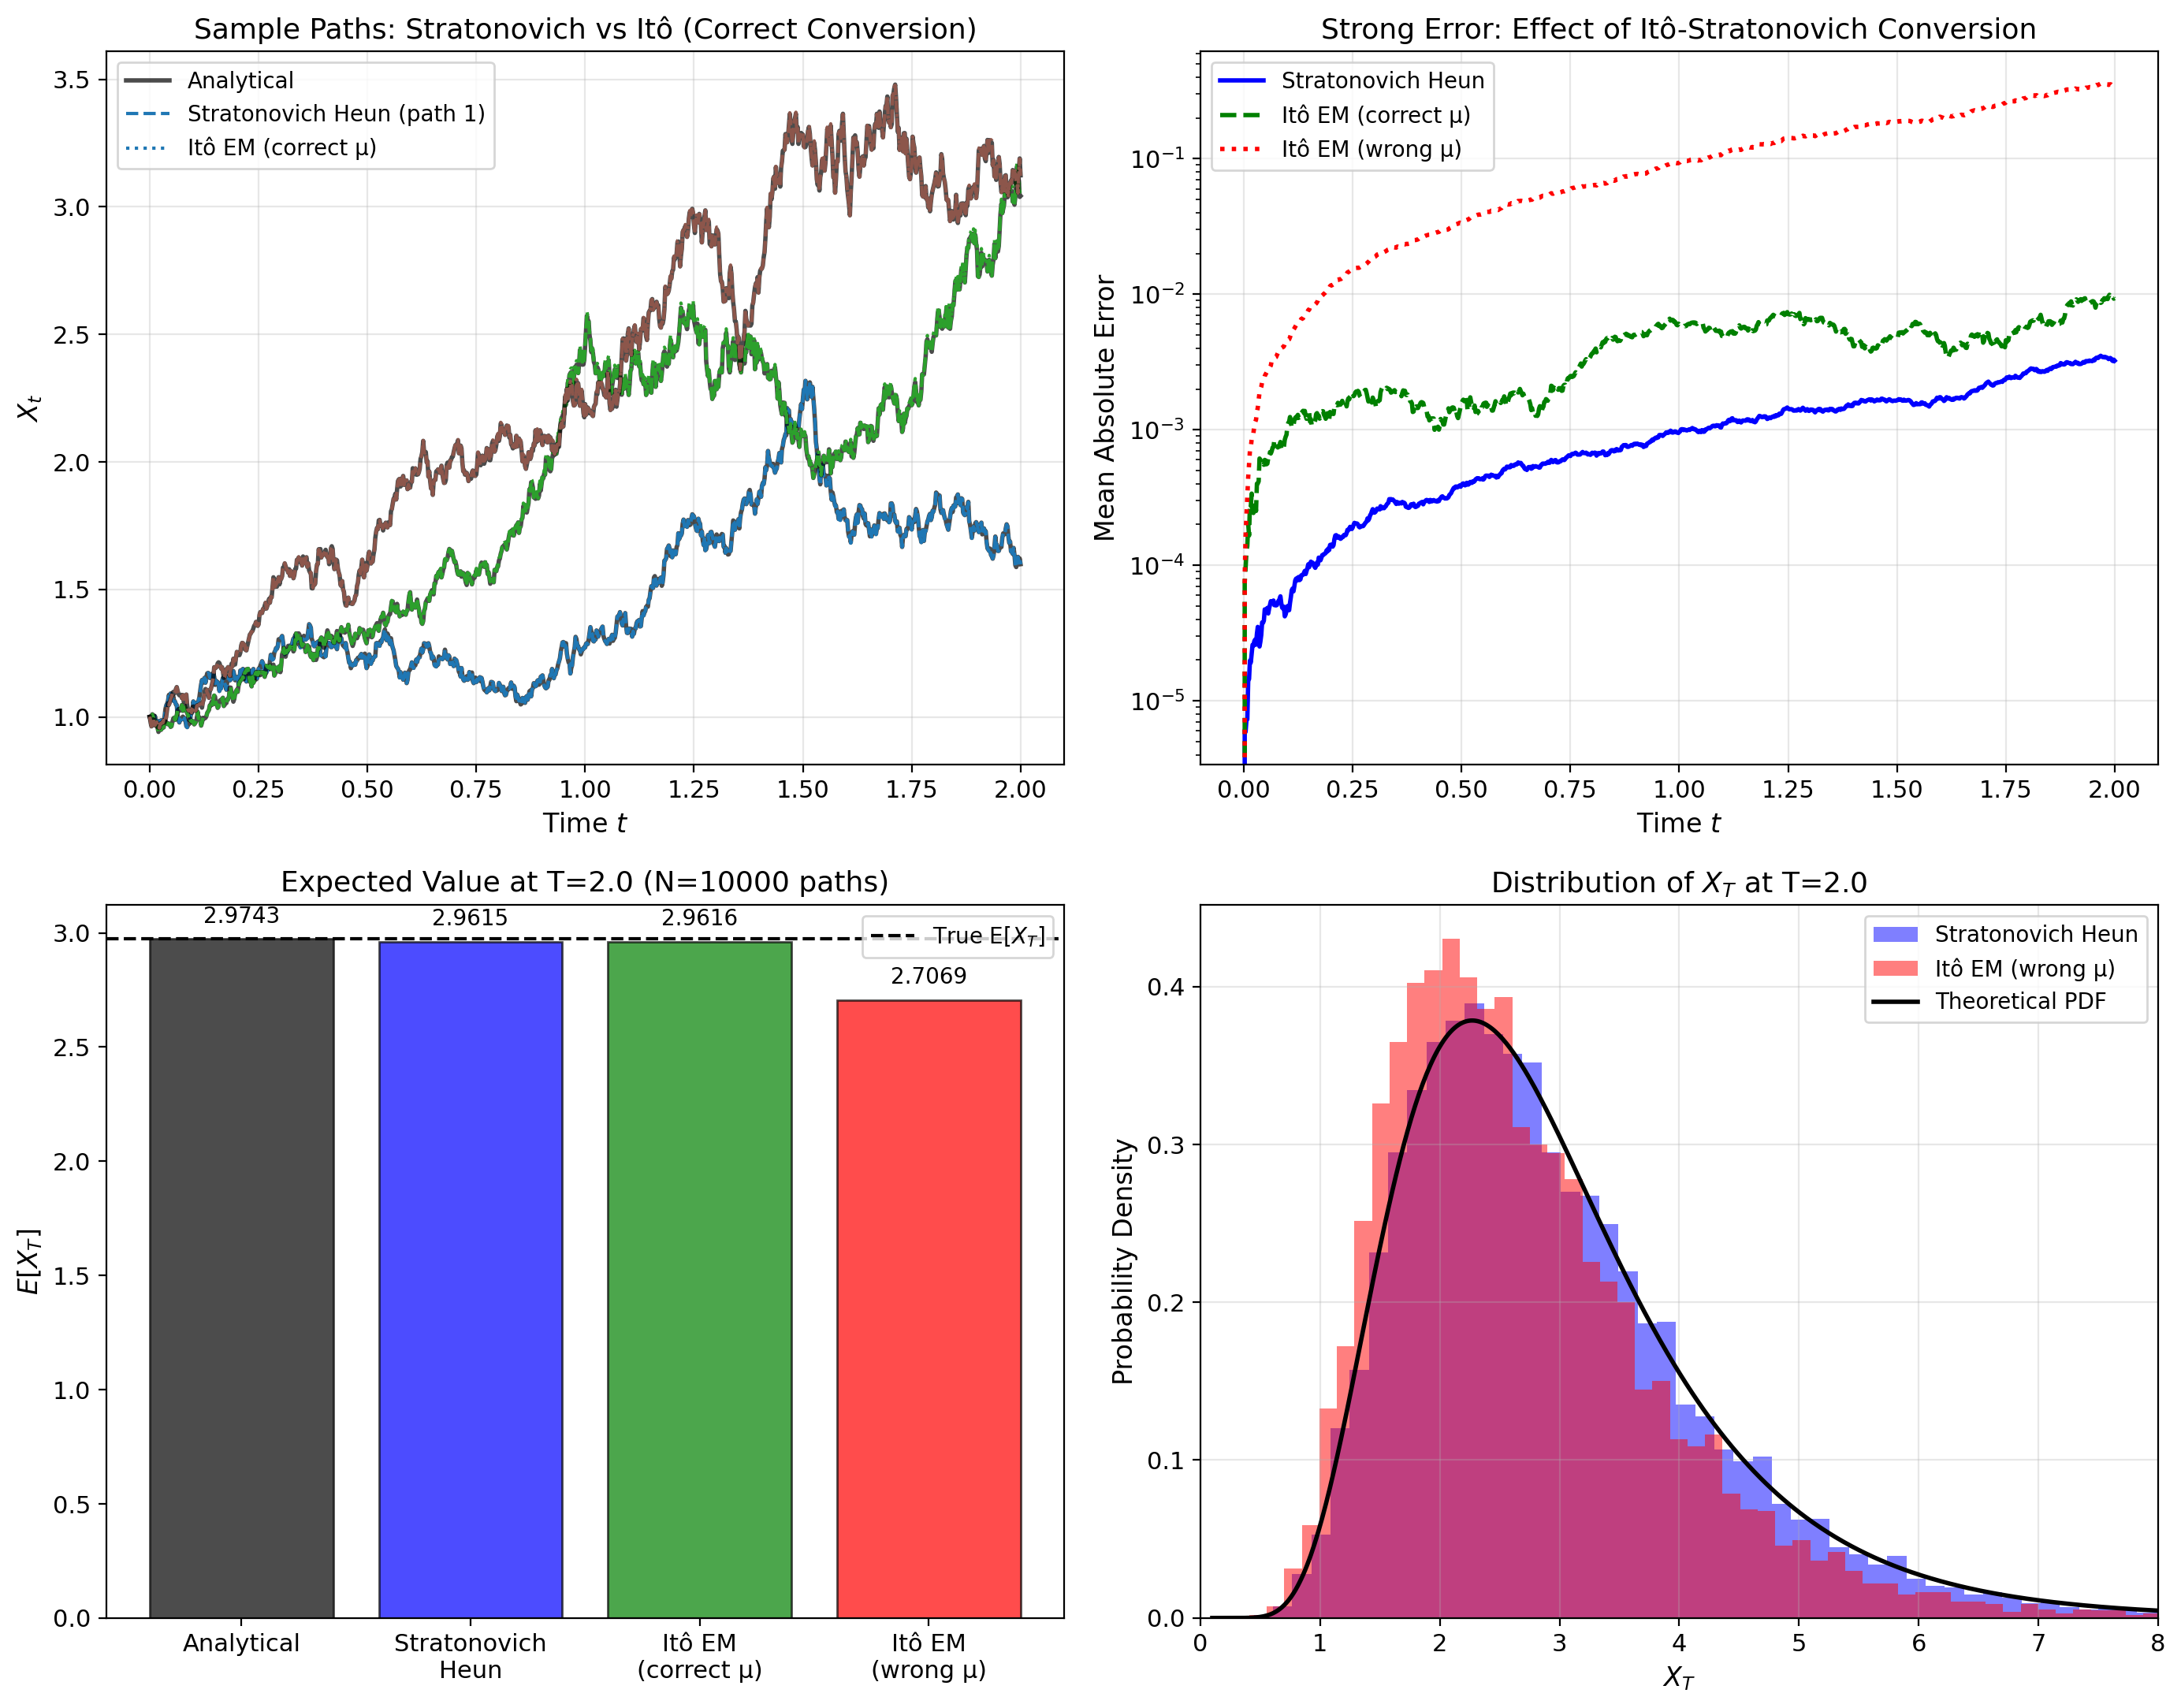


Statistical Summary at T=2.0:
Method                    Mean         Std Dev        Rel. Error
-----------------------------------------------------------------
Theoretical               2.974274     -                       -
Stratonovich Heun         2.961492     1.318947         0.4297%
Itô EM (correct μ)        2.961590     1.318474         0.4265%
Itô EM (wrong μ)          2.706943     1.205228         8.9881%


In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 11))

# Plot 1: Sample paths comparison
ax1 = axes[0, 0]
colors = plt.cm.tab10(np.linspace(0, 1, M))

for i in range(min(3, M)):
    ax1.plot(t_strat, X_analytical[i], 'k-', alpha=0.7, linewidth=2,
             label='Analytical' if i == 0 else '')
    ax1.plot(t_strat, X_strat[i], '--', color=colors[i], linewidth=1.5,
             label=f'Stratonovich Heun (path {i+1})' if i == 0 else '')
    ax1.plot(t_ito_correct, X_ito_correct[i], ':', color=colors[i], linewidth=1.5,
             label=f'Itô EM (correct μ)' if i == 0 else '')

ax1.set_xlabel('Time $t$')
ax1.set_ylabel('$X_t$')
ax1.set_title('Sample Paths: Stratonovich vs Itô (Correct Conversion)')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Error comparison
ax2 = axes[0, 1]

# Strong error (pathwise)
error_strat = np.abs(X_strat - X_analytical)
error_ito_correct = np.abs(X_ito_correct - X_analytical)
error_ito_wrong = np.abs(X_ito_wrong - X_analytical)

ax2.semilogy(t_strat, np.mean(error_strat, axis=0), 'b-', linewidth=2,
             label='Stratonovich Heun')
ax2.semilogy(t_ito_correct, np.mean(error_ito_correct, axis=0), 'g--', linewidth=2,
             label='Itô EM (correct μ)')
ax2.semilogy(t_ito_wrong, np.mean(error_ito_wrong, axis=0), 'r:', linewidth=2,
             label='Itô EM (wrong μ)')

ax2.set_xlabel('Time $t$')
ax2.set_ylabel('Mean Absolute Error')
ax2.set_title('Strong Error: Effect of Itô-Stratonovich Conversion')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Statistical comparison (many paths)
ax3 = axes[1, 0]

np.random.seed(456)
M_stat = 10000  # Many paths for statistics

_, X_strat_stat, dW_stat = stratonovich_heun(x0, mu, sigma, T, N, M_stat)
W_stat = np.zeros((M_stat, N + 1))
W_stat[:, 1:] = np.cumsum(dW_stat, axis=1)
X_analytical_stat = analytical_stratonovich_gbm(x0, mu, sigma, t_strat, W_stat)

np.random.seed(456)
_, X_ito_correct_stat, _ = euler_maruyama(x0, mu_ito, sigma, T, N, M_stat)

np.random.seed(456)
_, X_ito_wrong_stat, _ = euler_maruyama(x0, mu, sigma, T, N, M_stat)

# Expected value at final time
# For Stratonovich GBM: E[X_T] = X_0 * exp(μT + σ²T/2)
expected_strat = x0 * np.exp(mu * T + 0.5 * sigma**2 * T)

mean_strat = np.mean(X_strat_stat[:, -1])
mean_ito_correct = np.mean(X_ito_correct_stat[:, -1])
mean_ito_wrong = np.mean(X_ito_wrong_stat[:, -1])

categories = ['Analytical', 'Stratonovich\nHeun', 'Itô EM\n(correct μ)', 'Itô EM\n(wrong μ)']
means = [expected_strat, mean_strat, mean_ito_correct, mean_ito_wrong]
colors_bar = ['black', 'blue', 'green', 'red']

bars = ax3.bar(categories, means, color=colors_bar, alpha=0.7, edgecolor='black')
ax3.axhline(y=expected_strat, color='black', linestyle='--', linewidth=1.5, label='True E[$X_T$]')
ax3.set_ylabel('$E[X_T]$')
ax3.set_title(f'Expected Value at T={T} (N={M_stat} paths)')
ax3.legend()

for bar, mean in zip(bars, means):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f'{mean:.4f}', ha='center', va='bottom', fontsize=10)

# Plot 4: Distribution at final time
ax4 = axes[1, 1]

# Log-normal distribution parameters for Stratonovich GBM
# log(X_T) ~ N(log(X_0) + μT, σ²T)
log_mean = np.log(x0) + mu * T
log_std = sigma * np.sqrt(T)

x_range = np.linspace(0.1, 8, 500)
theoretical_pdf = stats.lognorm.pdf(x_range, s=log_std, scale=np.exp(log_mean))

ax4.hist(X_strat_stat[:, -1], bins=80, density=True, alpha=0.5, color='blue',
         label='Stratonovich Heun')
ax4.hist(X_ito_wrong_stat[:, -1], bins=80, density=True, alpha=0.5, color='red',
         label='Itô EM (wrong μ)')
ax4.plot(x_range, theoretical_pdf, 'k-', linewidth=2, label='Theoretical PDF')

ax4.set_xlabel('$X_T$')
ax4.set_ylabel('Probability Density')
ax4.set_title(f'Distribution of $X_T$ at T={T}')
ax4.set_xlim(0, 8)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plot.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nStatistical Summary at T={T}:")
print(f"{'Method':<25} {'Mean':<12} {'Std Dev':<12} {'Rel. Error':>12}")
print("-" * 65)
print(f"{'Theoretical':<25} {expected_strat:<12.6f} {'-':<12} {'-':>12}")
print(f"{'Stratonovich Heun':<25} {mean_strat:<12.6f} {np.std(X_strat_stat[:, -1]):<12.6f} {abs(mean_strat - expected_strat)/expected_strat*100:>10.4f}%")
print(f"{'Itô EM (correct μ)':<25} {mean_ito_correct:<12.6f} {np.std(X_ito_correct_stat[:, -1]):<12.6f} {abs(mean_ito_correct - expected_strat)/expected_strat*100:>10.4f}%")
print(f"{'Itô EM (wrong μ)':<25} {mean_ito_wrong:<12.6f} {np.std(X_ito_wrong_stat[:, -1]):<12.6f} {abs(mean_ito_wrong - expected_strat)/expected_strat*100:>10.4f}%")

## 5. Advanced Example: Multiplicative Noise SDE

Consider a more general nonlinear SDE with multiplicative noise:

$$dX_t = -\gamma X_t\,dt + \sigma X_t^\alpha \circ dW_t \quad \text{(Stratonovich)}$$

For $\alpha \neq 0, 1$, the Wong-Zakai correction becomes:

$$\frac{1}{2}b(x)b'(x) = \frac{1}{2}\sigma x^\alpha \cdot \sigma\alpha x^{\alpha-1} = \frac{\alpha\sigma^2}{2}x^{2\alpha-1}$$

The equivalent Itô form is:
$$dX_t = \left[-\gamma X_t + \frac{\alpha\sigma^2}{2}X_t^{2\alpha-1}\right]dt + \sigma X_t^\alpha\,dW_t$$

In [6]:
def stratonovich_heun_general(x0, drift_func, diffusion_func, T, N, M=1):
    """
    General Heun scheme for Stratonovich SDE:
    dX = a(X)*dt + b(X) o dW
    
    Parameters:
    -----------
    x0 : float - Initial condition
    drift_func : callable - Drift function a(x)
    diffusion_func : callable - Diffusion function b(x)
    T : float - Final time
    N : int - Number of time steps
    M : int - Number of sample paths
    """
    dt = T / N
    t = np.linspace(0, T, N + 1)
    dW = np.sqrt(dt) * np.random.randn(M, N)
    
    X = np.zeros((M, N + 1))
    X[:, 0] = x0
    
    for i in range(N):
        a_n = drift_func(X[:, i])
        b_n = diffusion_func(X[:, i])
        
        # Predictor
        X_pred = X[:, i] + a_n * dt + b_n * dW[:, i]
        X_pred = np.maximum(X_pred, 1e-10)  # Prevent negative values
        
        # Corrector
        b_pred = diffusion_func(X_pred)
        X[:, i+1] = X[:, i] + a_n * dt + 0.5 * (b_n + b_pred) * dW[:, i]
        X[:, i+1] = np.maximum(X[:, i+1], 1e-10)
    
    return t, X, dW


def euler_maruyama_general(x0, drift_func, diffusion_func, T, N, M=1):
    """
    General Euler-Maruyama scheme for Itô SDE:
    dX = a(X)*dt + b(X)*dW
    """
    dt = T / N
    t = np.linspace(0, T, N + 1)
    dW = np.sqrt(dt) * np.random.randn(M, N)
    
    X = np.zeros((M, N + 1))
    X[:, 0] = x0
    
    for i in range(N):
        a_n = drift_func(X[:, i])
        b_n = diffusion_func(X[:, i])
        X[:, i+1] = X[:, i] + a_n * dt + b_n * dW[:, i]
        X[:, i+1] = np.maximum(X[:, i+1], 1e-10)
    
    return t, X, dW

In [7]:
# Parameters for multiplicative noise example
x0 = 1.0
gamma = 0.5
sigma = 0.4
alpha = 0.5  # Square root diffusion
T = 3.0
N = 2000
M = 5000

# Stratonovich form: dX = -γX dt + σX^α o dW
def drift_strat(x):
    return -gamma * x

def diffusion(x):
    return sigma * np.power(np.maximum(x, 1e-10), alpha)

# Equivalent Itô form includes Wong-Zakai correction
def drift_ito_correct(x):
    x_safe = np.maximum(x, 1e-10)
    correction = 0.5 * alpha * sigma**2 * np.power(x_safe, 2*alpha - 1)
    return -gamma * x + correction

# Wrong Itô form (no correction)
def drift_ito_wrong(x):
    return -gamma * x

print(f"Stratonovich SDE: dX = -{gamma}X dt + {sigma}X^{alpha} o dW")
print(f"\nEquivalent Itô SDE: dX = [-{gamma}X + {0.5*alpha*sigma**2:.4f}X^{2*alpha-1:.1f}] dt + {sigma}X^{alpha} dW")
print(f"\nWong-Zakai correction term: {0.5*alpha*sigma**2:.4f}X^{2*alpha-1:.1f}")

Stratonovich SDE: dX = -0.5X dt + 0.4X^0.5 o dW

Equivalent Itô SDE: dX = [-0.5X + 0.0400X^0.0] dt + 0.4X^0.5 dW

Wong-Zakai correction term: 0.0400X^0.0


In [8]:
# Run simulations
np.random.seed(789)
t_strat, X_strat_nl, _ = stratonovich_heun_general(x0, drift_strat, diffusion, T, N, M)

np.random.seed(789)
t_ito, X_ito_correct_nl, _ = euler_maruyama_general(x0, drift_ito_correct, diffusion, T, N, M)

np.random.seed(789)
_, X_ito_wrong_nl, _ = euler_maruyama_general(x0, drift_ito_wrong, diffusion, T, N, M)

# Compute statistics over time
mean_strat_t = np.mean(X_strat_nl, axis=0)
mean_ito_correct_t = np.mean(X_ito_correct_nl, axis=0)
mean_ito_wrong_t = np.mean(X_ito_wrong_nl, axis=0)

std_strat_t = np.std(X_strat_nl, axis=0)
std_ito_correct_t = np.std(X_ito_correct_nl, axis=0)
std_ito_wrong_t = np.std(X_ito_wrong_nl, axis=0)

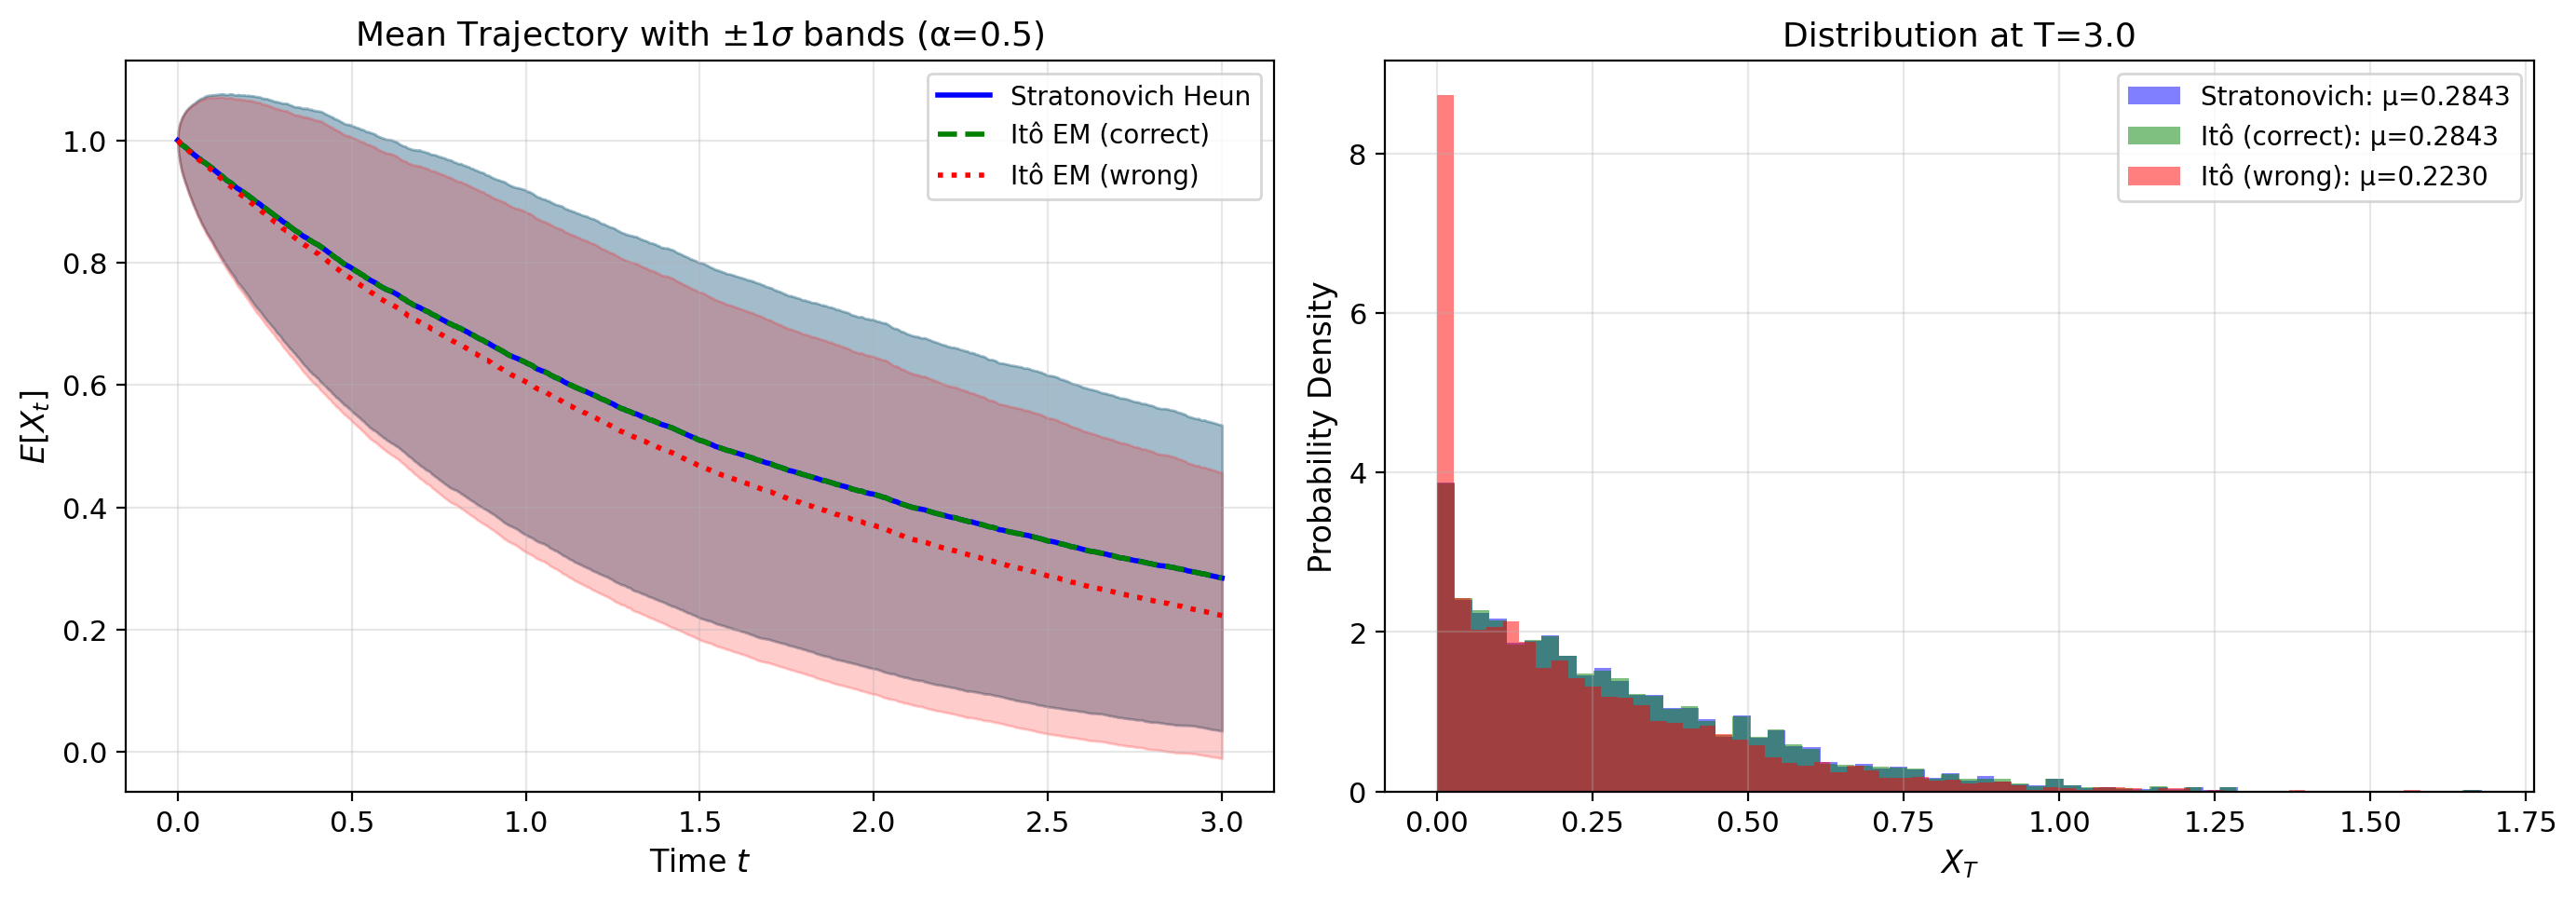

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot mean evolution
ax1 = axes[0]
ax1.plot(t_strat, mean_strat_t, 'b-', linewidth=2, label='Stratonovich Heun')
ax1.fill_between(t_strat, mean_strat_t - std_strat_t, mean_strat_t + std_strat_t,
                  alpha=0.2, color='blue')

ax1.plot(t_ito, mean_ito_correct_t, 'g--', linewidth=2, label='Itô EM (correct)')
ax1.fill_between(t_ito, mean_ito_correct_t - std_ito_correct_t, 
                  mean_ito_correct_t + std_ito_correct_t, alpha=0.2, color='green')

ax1.plot(t_ito, mean_ito_wrong_t, 'r:', linewidth=2, label='Itô EM (wrong)')
ax1.fill_between(t_ito, mean_ito_wrong_t - std_ito_wrong_t,
                  mean_ito_wrong_t + std_ito_wrong_t, alpha=0.2, color='red')

ax1.set_xlabel('Time $t$')
ax1.set_ylabel('$E[X_t]$')
ax1.set_title(f'Mean Trajectory with $\\pm 1\\sigma$ bands (α={alpha})')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot final time distributions
ax2 = axes[1]
ax2.hist(X_strat_nl[:, -1], bins=60, density=True, alpha=0.5, color='blue',
         label=f'Stratonovich: μ={np.mean(X_strat_nl[:, -1]):.4f}')
ax2.hist(X_ito_correct_nl[:, -1], bins=60, density=True, alpha=0.5, color='green',
         label=f'Itô (correct): μ={np.mean(X_ito_correct_nl[:, -1]):.4f}')
ax2.hist(X_ito_wrong_nl[:, -1], bins=60, density=True, alpha=0.5, color='red',
         label=f'Itô (wrong): μ={np.mean(X_ito_wrong_nl[:, -1]):.4f}')

ax2.set_xlabel('$X_T$')
ax2.set_ylabel('Probability Density')
ax2.set_title(f'Distribution at T={T}')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plot.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Convergence Analysis

Let's verify the strong convergence orders of our numerical schemes:
- **Euler-Maruyama (Itô)**: Strong order 0.5
- **Heun (Stratonovich)**: Strong order 1.0

In [10]:
def convergence_analysis(x0, mu, sigma, T, N_values, M_conv=1000):
    """
    Analyze strong convergence of numerical schemes.
    Uses a fine-resolution reference solution.
    """
    # Reference solution with very fine resolution
    N_ref = max(N_values) * 16
    dt_ref = T / N_ref
    
    np.random.seed(999)
    dW_ref = np.sqrt(dt_ref) * np.random.randn(M_conv, N_ref)
    W_ref = np.zeros((M_conv, N_ref + 1))
    W_ref[:, 1:] = np.cumsum(dW_ref, axis=1)
    
    # Analytical solution at final time
    X_exact = analytical_stratonovich_gbm(x0, mu, sigma, T, W_ref[:, -1])
    
    mu_ito = mu + 0.5 * sigma**2
    
    errors_em = []
    errors_heun = []
    dt_values = []
    
    for N in N_values:
        dt = T / N
        dt_values.append(dt)
        
        # Subsample Wiener process
        step_ratio = N_ref // N
        dW_coarse = np.sum(dW_ref.reshape(M_conv, N, step_ratio), axis=2)
        
        # Euler-Maruyama
        X_em = np.zeros((M_conv, N + 1))
        X_em[:, 0] = x0
        for i in range(N):
            X_em[:, i+1] = X_em[:, i] + mu_ito * X_em[:, i] * dt + sigma * X_em[:, i] * dW_coarse[:, i]
        
        # Heun (Stratonovich)
        X_heun = np.zeros((M_conv, N + 1))
        X_heun[:, 0] = x0
        for i in range(N):
            X_pred = X_heun[:, i] + mu * X_heun[:, i] * dt + sigma * X_heun[:, i] * dW_coarse[:, i]
            X_heun[:, i+1] = X_heun[:, i] + mu * X_heun[:, i] * dt + 0.5 * sigma * (X_heun[:, i] + X_pred) * dW_coarse[:, i]
        
        # Strong errors
        errors_em.append(np.mean(np.abs(X_em[:, -1] - X_exact)))
        errors_heun.append(np.mean(np.abs(X_heun[:, -1] - X_exact)))
    
    return np.array(dt_values), np.array(errors_em), np.array(errors_heun)

# Run convergence analysis
N_values = [32, 64, 128, 256, 512, 1024]
dt_vals, err_em, err_heun = convergence_analysis(1.0, 0.5, 0.3, 1.0, N_values)

# Compute convergence orders
log_dt = np.log(dt_vals)
log_err_em = np.log(err_em)
log_err_heun = np.log(err_heun)

order_em = np.polyfit(log_dt, log_err_em, 1)[0]
order_heun = np.polyfit(log_dt, log_err_heun, 1)[0]

print(f"Estimated strong convergence orders:")
print(f"  Euler-Maruyama (Itô): {order_em:.3f} (theoretical: 0.5)")
print(f"  Heun (Stratonovich):  {order_heun:.3f} (theoretical: 1.0)")

Estimated strong convergence orders:
  Euler-Maruyama (Itô): 0.519 (theoretical: 0.5)
  Heun (Stratonovich):  0.995 (theoretical: 1.0)


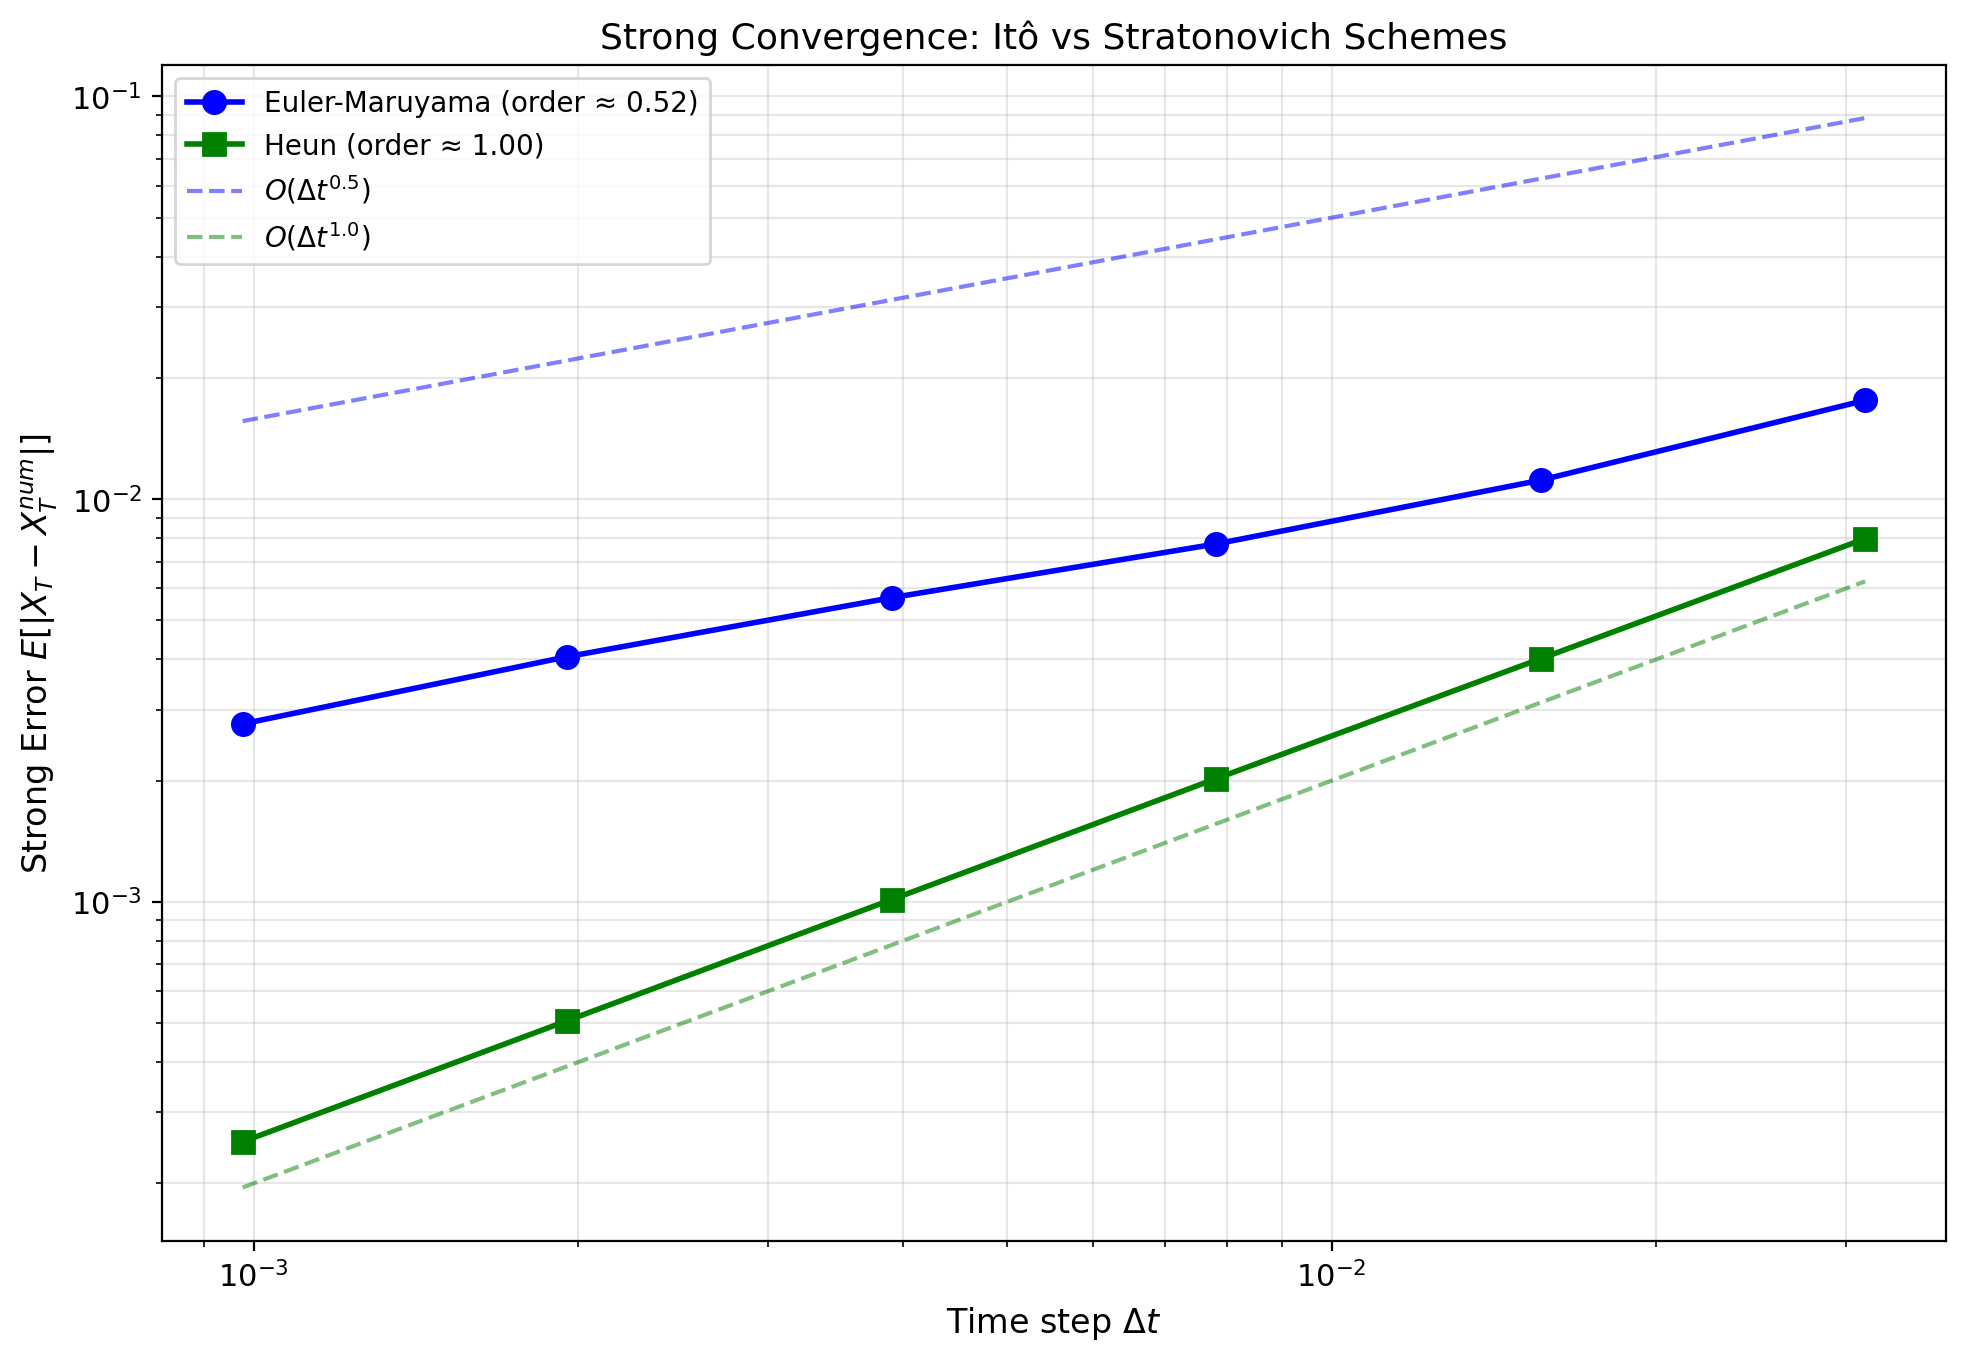

In [11]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.loglog(dt_vals, err_em, 'bo-', markersize=8, linewidth=2,
          label=f'Euler-Maruyama (order ≈ {order_em:.2f})')
ax.loglog(dt_vals, err_heun, 'gs-', markersize=8, linewidth=2,
          label=f'Heun (order ≈ {order_heun:.2f})')

# Reference lines
dt_range = np.array([dt_vals.min(), dt_vals.max()])
ax.loglog(dt_range, 0.5 * dt_range**0.5, 'b--', alpha=0.5, label='$O(\\Delta t^{0.5})$')
ax.loglog(dt_range, 0.2 * dt_range**1.0, 'g--', alpha=0.5, label='$O(\\Delta t^{1.0})$')

ax.set_xlabel('Time step $\\Delta t$')
ax.set_ylabel('Strong Error $E[|X_T - X_T^{num}|]$')
ax.set_title('Strong Convergence: Itô vs Stratonovich Schemes')
ax.legend()
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig('plot.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Summary and Key Takeaways

### 7.1 When to Use Stratonovich Calculus

1. **Physical Systems**: When noise originates from smooth underlying processes (Wong-Zakai theorem applies)
2. **Geometric Problems**: Stochastic differential geometry, where coordinate transformations must be preserved
3. **Conservation Laws**: Systems where the chain rule must hold for energy or other conserved quantities

### 7.2 Practical Guidelines

| Aspect | Itô | Stratonovich |
|--------|-----|-------------|
| Chain rule | Modified (Itô formula) | Standard |
| Martingale property | Yes | No |
| Physical interpretation | Finance, filtering | Physics, geometry |
| Numerical scheme | Euler-Maruyama | Heun/Milstein |

### 7.3 Conversion Checklist

When converting from Stratonovich to Itô:
1. Identify the diffusion coefficient $b(X_t)$
2. Compute the derivative $b'(X_t)$
3. Add the Wong-Zakai correction $\frac{1}{2}b(X_t)b'(X_t)$ to the drift

$$a_{\text{Itô}}(x) = a_{\text{Strat}}(x) + \frac{1}{2}b(x)b'(x)$$

In [12]:
print("Notebook execution completed successfully.")
print("Final plot saved to: plot.png")

Notebook execution completed successfully.
Final plot saved to: plot.png
